In [123]:
import os

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as F

In [134]:
%%bash

bash download-data.bash

In [135]:
# copied from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#visualization-utilities
def show_images(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [136]:
model = torchvision.models.segmentation.lraspp_mobilenet_v3_large(pretrained=True)
model.eval()
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 3221538


In [137]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, train):
        self.dir = 'data/val2017'
        img_names = os.listdir(self.dir)
        num_imgs = len(img_names)
        num_train_imgs = 8 * num_imgs // 10
        self.img_names = img_names[:num_train_imgs] if train else img_names[num_train_imgs:]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir, self.img_names[idx])
        image = torchvision.io.read_image(img_path)
        return image

train_data = torch.utils.data.DataLoader(CocoDataset(train=True), batch_size=1, shuffle=True)

In [138]:
classes = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
class_to_index = {class_name: i for (i, class_name) in enumerate(classes)}

In [253]:
# `batch` should be a float tensor with values between 0 and 1
def get_segmentation_logits(model, batch):   
    normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    output = model(normalized_batch)['out']
    return output

# `batch_int` should be a uint8 tensor
def show_segmentation(model, batch_int):
    batch = F.convert_image_dtype(batch_int, torch.float32) 
    with torch.no_grad():
        logits = get_segmentation_logits(model, batch)
    num_classes = logits.shape[1]

    class_dim = 1
    mask_by_class = logits.argmax(1) == torch.arange(num_classes)[:, None, None, None]
    mask_by_class = einops.rearrange(mask_by_class, 'class batch w h -> batch class w h')

    masked_imgs = [
        torchvision.utils.draw_segmentation_masks(img, masks=mask, alpha=.6)
        for img, mask in zip(batch_int, mask_by_class)
    ]
    show_images(masked_imgs)

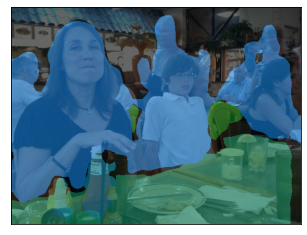

In [255]:
batch_int = next(iter(train_data))
show_segmentation(model, batch_int)

In [293]:
class Perturbation(torch.nn.Module):
    def __init__(self, tile_size, max_magnitude):
        super(Perturbation, self).__init__()
        self.tile_size = tile_size
        self.perturbation = torch.nn.Parameter(torch.randn(3, self.tile_size, self.tile_size,))
        self.max_magnitude = max_magnitude
        self.clip()
    
    def forward(self, img):
        # The perturbation likely doesn't have the same dimensions as the image.
        # Tile the perturbation to make the dimensions match
        height, width = img.shape[-2:]
        h_repeat = (height + self.tile_size - 1) // self.tile_size
        w_repeat = (width + self.tile_size - 1) // self.tile_size
        tiled_perturbation = torch.tile(self.perturbation, (h_repeat, w_repeat))
        tiled_perturbation = torch.narrow(tiled_perturbation, -2, 0, height)
        tiled_perturbation = torch.narrow(tiled_perturbation, -1, 0, width)
        
        img = torch.clamp(img + tiled_perturbation, min=0, max=255)
        return img
    
    def clip(self):
        with torch.no_grad():
            self.perturbation.clamp_(min=-self.max_magnitude, max=self.max_magnitude)
            
    def show(self):
        with torch.no_grad():
            perturbation = self.perturbation * 255 / (2 * self.max_magnitude) + 127.5
        show_images(perturbation.byte())

In [344]:
# The loss function is the cross-entropy loss, except that pixels
# that already match the target class with confidence above 
# `confidence_threshold` are ignored.
def make_loss_fn(confidence_threshold = 0.75):
    cross_entropy_fn = torch.nn.CrossEntropyLoss(reduction='sum')
    def loss_fn(logits, target):
        num_pixels = target.numel()
        
        probs = logits.softmax(dim=1)
        target_probs = torch.gather(probs, 1, target.unsqueeze(1)).squeeze(1)
        bad_indices = target_probs < confidence_threshold
        
        target = torch.masked_select(target, bad_indices)
        logits = einops.rearrange(logits, 'batch class h w -> class batch h w')
        logits = torch.masked_select(logits, bad_indices)
        logits = einops.rearrange(logits, '(class pixel) -> pixel class', pixel=target.shape[0])
        
        return cross_entropy_fn(logits, target) / num_pixels
    return loss_fn

In [349]:
# first let's see if we can get an adversarial perturbation on a single image
perturbation = Perturbation(tile_size=256, max_magnitude=10)
background_class_index = class_to_index['background']
person_class_index = class_to_index['person']

num_iters = 100
lr = 0.1
optimizer = torch.optim.Adam(perturbation.parameters(), lr=lr)
loss_fn = make_loss_fn()

batch = F.convert_image_dtype(batch_int, torch.float32) 
with torch.no_grad():
    segmentation = get_segmentation_logits(model, batch).argmax(1)
target = segmentation.clone()
# For simplicity, for each person-classified pixel, let's make the target class be the
# background class instead of making it be the same class as the nearest 
# non-person-classified label. This seems more natural for this data set (as opposed to the
# Cityscapes data set) anyway since most pixels in this data set are the background class.
target[segmentation == person_class_index] = background_class_index

In [350]:
for i in range(num_iters):
    optimizer.zero_grad()
    
    perturbed_batch = perturbation(batch_int)
    logits = get_segmentation_logits(model, perturbed_batch / 255)
    loss = loss_fn(logits, target)
    
    loss.backward()
    if i % (num_iters // 10) == 0:
        print(f"{i=} {loss=}")
    optimizer.step()
    perturbation.clip()    

i=0 loss=tensor(1.9173, grad_fn=<DivBackward0>)
i=10 loss=tensor(0.8980, grad_fn=<DivBackward0>)
i=20 loss=tensor(0.3952, grad_fn=<DivBackward0>)
i=30 loss=tensor(0.2684, grad_fn=<DivBackward0>)
i=40 loss=tensor(0.1845, grad_fn=<DivBackward0>)
i=50 loss=tensor(0.1366, grad_fn=<DivBackward0>)
i=60 loss=tensor(0.1132, grad_fn=<DivBackward0>)
i=70 loss=tensor(0.0978, grad_fn=<DivBackward0>)
i=80 loss=tensor(0.0866, grad_fn=<DivBackward0>)
i=90 loss=tensor(0.0779, grad_fn=<DivBackward0>)


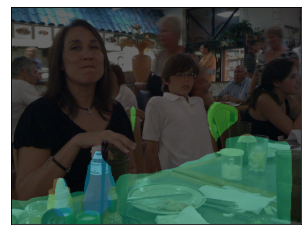

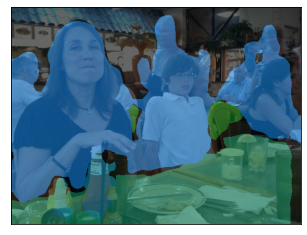

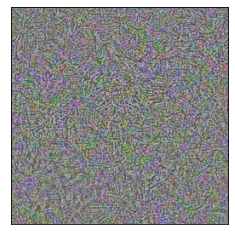

In [351]:
with torch.no_grad():
    perturbed_batch = perturbation(batch_int)
    show_segmentation(model, perturbed_batch.byte())
    show_segmentation(model, batch_int)
    perturbation.show()